# Similarity Training Ensemble on MNIST Dataset 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nengo
import numpy as np
import scipy.ndimage
from scipy.ndimage.interpolation import rotate
import matplotlib.animation as animation
from matplotlib import pylab
from PIL import Image
import nengo.spa as spa
import pickle
import random

from nengo_extras.data import load_mnist
from nengo_extras.vision import Gabor, Mask

from skimage.measure import compare_ssim as ssim

Load the MNIST training and testing images

In [2]:
# --- load the data
img_rows, img_cols = 28, 28

(X_train, y_train), (X_test, y_test) = load_mnist()

X_train = 2 * X_train - 1  # normalize to -1 to 1
X_test = 2 * X_test - 1  # normalize to -1 to 1


## Create array of images and rotated pairs and list of structural similarities
Each set of images contains an upright image and an image rotated at random amount

In [3]:
random.seed(1)

#List of images
imgs = X_train.copy()
#Rotated images
rot_imgs = X_train.copy()
for img in rot_imgs:
    img[:] = scipy.ndimage.interpolation.rotate(np.reshape(img,(28,28)),
                                                random.randint(1,360),reshape=False,mode="nearest").ravel()

#List of calculated similarities
similarities = np.ndarray((len(imgs),1))
for i in range(len(imgs)):
    similarities[i] = ssim(imgs[i].reshape(28,28),rot_imgs[i].reshape(28,28))

#Remove negative values, doesn't really change output
#similarities[similarities<0]=0


[0.10749062]


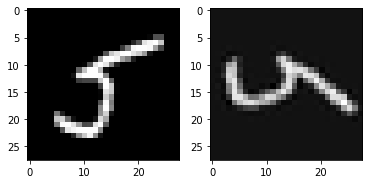

In [4]:
#Check to see if images and similarity generated correctly
index = np.random.randint(1,60000)

plt.subplot(121)
plt.imshow(np.reshape(imgs[index],(28,28)),cmap="gray")
plt.subplot(122)
plt.imshow(np.reshape(rot_imgs[index],(28,28)),cmap="gray")

#plt.imshow(np.reshape(imgs[index],(28*2,28)),cmap="gray")


#similarity = ssim(imgs[index][:28**2].reshape(28,28),imgs[index][28**2:].reshape(28,28))
similarity = similarities[index]
print(similarity)

## The Network
- The network parameters must be the same here as when the weight matrices are used later on
- The network is made up of an ensemble and a node
  - The connection (to v) computes the weights from the activities of the images to their similarites
- Network is the same as was used for training rotation so that it can be used later on.
  
  

In [5]:
X_train.shape

(60000, 784)

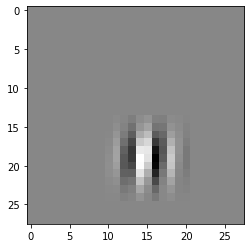

In [6]:
rng = np.random.RandomState(9)

# --- set up network parameters
#Want to map from images to similarity
n_vis = X_train.shape[1] #imgs.shape[1]
n_out =  similarities.shape[1]
#number of neurons/dimensions of semantic pointer
n_hid = 5000 #Try with more neurons for more accuracy-


#Want the encoding/decoding done on the training images
ens_params = dict(
    eval_points=X_train, #imgs, 
    neuron_type=nengo.LIF(), #originally used LIFRate()
    intercepts=nengo.dists.Choice([-0.5]),
    max_rates=nengo.dists.Choice([100]),
    )


#Least-squares solver with L2 regularization.
solver = nengo.solvers.LstsqL2(reg=0.01)
#solver = nengo.solvers.LstsqL2(reg=0.0001)

#network that generates the weight matrices between neuron activity and images and the labels
with nengo.Network(seed=3) as model:
    a = nengo.Ensemble(n_hid, n_vis, seed=3, **ens_params)
    v = nengo.Node(size_in=n_out)
    conn = nengo.Connection(
        a, v, synapse=None,
        eval_points=imgs, function=similarities,#want the similarities out
        solver=solver)
    


# linear filter used for edge detection as encoders, more plausible for human visual system
encoders = Gabor().generate(n_hid, (11, 11), rng=rng)
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
#Set the ensembles encoders to this
a.encoders = encoders

#Check the encoders were correctly made
plt.imshow(encoders[0].reshape(28, 28), vmin=encoders[0].min(), vmax=encoders[0].max(), cmap='gray')


## Evaluating the network statically
- Functions for computing representation of the image at different levels of encoding/decoding
- get_outs  returns the output of the network
- able to evaluate on many images
- no need to run the simulator

In [7]:
#Get the neuron activity of an image or group of images (this is the semantic pointer in this case)
def get_activities(sim, images):
    _, acts = nengo.utils.ensemble.tuning_curves(a, sim, inputs=images)
    return acts

#Get similarity of activity using dot product
def get_dots(imgs):
    dots = np.ndarray((60000,1))
    for i in range(len(imgs)):
        dots[i] = np.dot(imgs[i][:5000],imgs[i][5000:])
    
    return dots

## Simulator
- Generate the weight matrices between 
  - activities of image pairs and structural similarites
  - activities of image pairs and dot procut of their activities

In [8]:
with nengo.Simulator(model) as sim:    
    
    #Neuron activities of different mnist image pairs
    orig_acts = get_activities(sim,imgs)
    rot_acts = get_activities(sim,rot_imgs)
    
    acts = np.ndarray((orig_acts.shape[0],orig_acts.shape[1]*2))
    for i in range(len(acts)):
        acts[i] = np.append(orig_acts[i],rot_acts[i])
    

    dot_similarities = get_dots(acts)

    
    #solvers for a learning rule
    solver = nengo.solvers.LstsqL2(reg=1e-8)
    solver_ssim = nengo.solvers.LstsqL2(reg=1e-8)

    #find weight matrix between neuron activity of the original image pair and the dot product of activities
    #weights returns a tuple including information about learning process, just want the weight matrix
    weights,_ = solver(acts, dot_similarities)
    
    weights_ssim,_ = solver_ssim(acts,similarities)
    
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Testing the outputs

[30487267.41641565]
[0.64514074]


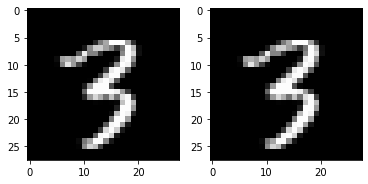

In [14]:
test1 = X_test[random.randint(1,10000)]

test2 = scipy.ndimage.interpolation.rotate(np.reshape(test1,(28,28)),
                                                random.randint(0,0),reshape=False,mode="nearest").ravel()
pylab.subplot(121)
pylab.imshow(test1.reshape(28,28),cmap='gray')
pylab.subplot(122)
pylab.imshow(test2.reshape(28,28),cmap='gray')


_,act1 = nengo.utils.ensemble.tuning_curves(a, sim, inputs=test1)
_,act2 = nengo.utils.ensemble.tuning_curves(a, sim, inputs=test2)

act = np.append(act1,act2)


print(np.dot(act,weights))
print(np.dot(act,weights_ssim))

# Saving weight matrices


In [11]:
filename = "two_img_similarity_dot_weights" + str(n_hid*2) +".p"
pickle.dump(weights.T, open( filename, "wb" ) )

filename = "two_img_similarity_ssim_weights" + str(n_hid*2) +".p"
pickle.dump(weights_ssim.T, open( filename, "wb" ) )

